In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

from scipy.sparse import lil_matrix
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

/usr/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Unpickling
import pickle
filename='filtered_data'
infile = open(filename,'rb')
final=pickle.load(infile)
infile.close()

In [3]:
X_TSVD=final['CleanedText']

In [4]:
X_train_2=X_TSVD.tolist()

# WordCloud

In [5]:
from wordcloud import WordCloud

def wordclouds(string):   
    words = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    max_words=2000, 
                    min_font_size = 10)
    wc=words.generate(string)    
    return wc

def Print_clusters(model):
    
    #Picking top 5 clusters for wordcloud
    unique, counts = np.unique(model.labels_, return_counts=True)
    a=sorted(dict(zip(unique, counts)).items(), key=lambda x: x[1],reverse=True)
    clusters= [i[0] for i in a[0:5]]
    
    #ploting top 5 clusters
    fig = plt.figure(figsize = (20,20))
    count = 1
    for i in clusters:
        str1=""
        #print("Cluster:%d" %i)
        for j in np.where(model.labels_ == i)[0]:
            str1+=X_train_2[j]
            str1+=" "
        word=wordclouds(str1)
        fig.add_subplot(4,4,count)
        plt.imshow(word) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.title("Cluster:%d" %i)
        count+=1
    plt.show() 
    print ("\n") 

In [6]:
import pickle

filename='X_TSVD'
outfile=open(filename,'wb')
pickle.dump(X_TSVD, outfile)
outfile.close()

In [7]:
filename='X_TSVD'
infile = open(filename,'rb')
X_TSVD=pickle.load(infile)
infile.close()

# TFIDF-Picking Top 2000 words

In [8]:
#TF-IDF
tf_idf_vect = TfidfVectorizer()
X_TSVD_tf_idf = tf_idf_vect.fit_transform(X_TSVD)

filename='tf_idf_vect_TSVD'
outfile=open(filename,'wb')
pickle.dump(tf_idf_vect, outfile)
outfile.close()

filename='X_TSVD_tf_idf'
outfile=open(filename,'wb')
pickle.dump(X_TSVD_tf_idf, outfile)
outfile.close()

In [9]:
#Vocabulary generation
vocab=tf_idf_vect.vocabulary_

In [10]:
#generating features names
features = tf_idf_vect.get_feature_names()

In [11]:
# source: https://buhrmann.github.io/tfidf-analysis.html
#Picking top 2000 feature names
def top_tfidf_feats(row, features, top_n=2000):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [features[i] for i in topn_ids]
    return top_feats

top_tfidf = top_tfidf_feats(X_TSVD_tf_idf[1,:].toarray()[0],features,2000)

# Co-Occurance Matrix

In [12]:
from tqdm import tqdm
coocur_matrix = lil_matrix((len(vocab)+1, len(vocab)+1), dtype=np.float64)
window_size=5
try:
    for review in tqdm(X_TSVD): 
        doc_tokens = word_tokenize(review)
        N = len(doc_tokens)
        for token in top_tfidf:
            for i in range(0,window_size):
                try:
                    if (token in doc_tokens[0:i] or token in doc_tokens[i:(i+window_size+1)]) and token != doc_tokens[i]:
                        coocur_matrix[vocab[doc_tokens[i]],vocab[token]] +=1
                except:pass
            for i in range(window_size, (N-window_size)):
                try:
                    if token in doc_tokens[(i-window_size):(i+window_size+1)] and token != doc_tokens[i]:
                        coocur_matrix[vocab[doc_tokens[i]],vocab[token]] +=1
                except:pass
            for i in range(N-window_size, N):
                try:
                    if (token in doc_tokens[i:N] or token in doc_tokens[i-window_size:N]) and token != doc_tokens[i]:
                        coocur_matrix[vocab[doc_tokens[i]],vocab[token]] +=1
                except:pass
except:
    pass

100%|██████████| 87773/87773 [1:18:00<00:00, 18.75it/s]


In [22]:
coocur_matrix.shape

(34182, 34182)

In [14]:
filename='coocur_matrix_SVD'
outfile=open(filename,'wb')
pickle.dump(coocur_matrix, outfile)
outfile.close()

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/ashish_28594/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Optimal k-value for TruncatedSVD

In [41]:
from sklearn.decomposition import TruncatedSVD
optimal_K2=range(50,151,10)
scores2=[]
for i in optimal_K2:
    truncate=TruncatedSVD(n_components=i, random_state=0)
    X_SVD=truncate.fit_transform(coocur_matrix)
    scores2.append(truncate.explained_variance_ratio_.sum()*100)


The optimal K is : 150


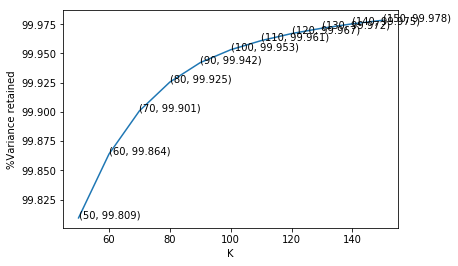

('%Variance retained for each K : ', array([99.809, 99.864, 99.901, 99.925, 99.942, 99.953, 99.961, 99.967,
       99.972, 99.975, 99.978]))


In [42]:
K2 = optimal_K2[scores2.index(max(scores2))]
print('\nThe optimal K is : {}'.format(K2))
plt.plot(optimal_K2, scores2)

for xy in zip(optimal_K2, np.round(scores2,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('K')
plt.ylabel('%Variance retained')
plt.show()
print("%Variance retained for each K : ", np.round(scores2,3)) 

In [44]:
filename='X_SVD'
outfile=open(filename,'wb')
pickle.dump(X_SVD, outfile)
outfile.close()

In [47]:
X_SVD2=np.array(X_SVD)

In [55]:
X_SVD2.shape

(34182, 150)

# Optimal Number of Clusters


The optimal cluster is : 50


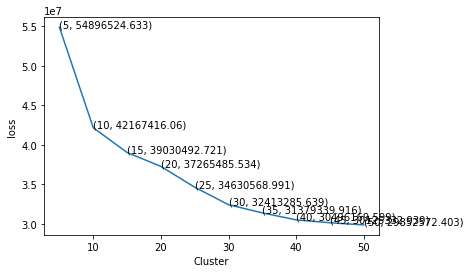

('the loss  for each cluster value is : ', array([54896524.633, 42167416.06 , 39030492.721, 37265485.534,
       34630568.991, 32413285.639, 31379339.916, 30496169.599,
       30125332.939, 29852572.403]))


In [51]:
#Finding Optimal Number of clusters
from sklearn.cluster import KMeans

n_clusters = range(5,51,5)

    # empty list that will hold cv scores
cv_scores = []

    # perform 10-fold cross validation
for cluster in n_clusters:
    kmeans =KMeans(init='k-means++',random_state=0,n_clusters=cluster)
    scores = cross_val_score(kmeans, X_SVD2, cv=5,n_jobs=-1)
    cv_scores.append(scores.mean())

    # changing to misclassification error
MSE = [1 - x for x in cv_scores]

    # determining best max_depth
optimal_cluster = n_clusters[MSE.index(min(MSE))]

print('\nThe optimal cluster is : {}'.format(optimal_cluster))
# plot misclassification error vs depth 
plt.plot(n_clusters, MSE)

for xy in zip(n_clusters, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Cluster')
plt.ylabel('loss')
plt.show()
print("the loss  for each cluster value is : ", np.round(MSE,3)) 

In [52]:
#Number of reviews in each cluster
model5=KMeans(init='k-means++',random_state=0,n_clusters=optimal_cluster,n_jobs=-1).fit(coocur_matrix)
unique1, counts1 = np.unique(model5.labels_, return_counts=True)
dict(zip(unique1, counts1))

{0: 31751,
 1: 2,
 2: 36,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 435,
 8: 15,
 9: 1,
 10: 1,
 11: 2,
 12: 8,
 13: 1,
 14: 1,
 15: 1,
 16: 26,
 17: 1,
 18: 1,
 19: 120,
 20: 10,
 21: 1,
 22: 5,
 23: 1,
 24: 1,
 25: 5,
 26: 4,
 27: 2,
 28: 32,
 29: 219,
 30: 1,
 31: 1,
 32: 1,
 33: 3,
 34: 9,
 35: 93,
 36: 1,
 37: 26,
 38: 1,
 39: 20,
 40: 1,
 41: 1,
 42: 1,
 43: 3,
 44: 1,
 45: 35,
 46: 8,
 47: 5,
 48: 1284,
 49: 1}

In [54]:
filename='model5_SVD'
outfile=open(filename,'wb')
pickle.dump(model5, outfile)
outfile.close()

In [ ]:
# Reading Top 5 clusters form WOrdcloud
Print_clusters(model5)

# Conclusion

Here the top 5 clusters are related mostly to taste and flavour of food products like tea,coffe,cookies and very are describing about animal food products.